In [ ]:
# os stuff
import sys
from os import makedirs, listdir, mkdir
from os.path import join, basename, splitext, exists, split, normpath, sep, isdir
from shutil import copytree, rmtree
# progress bar
from tqdm.auto import tqdm
# colab drive
from google.colab import drive
# mathematicl library
import numpy as np
# cv
import cv2
from google.colab.patches import cv2_imshow
# matplotlib
import matplotlib.pyplot as plt
# some functions from sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
# pandas for classifcation report
import pandas as pd
# set precision
pd.set_option('precision', 2)
from IPython.display import display_html 
# torch related libraries
import torch
import torch.utils.data
from torch import nn, Tensor
from torch.nn import functional as F
from torch.autograd import Variable, Function
from torchvision import datasets, transforms, models
from scipy.special import softmax
# color and image manipulation
import colorsys
from PIL import Image, ImageDraw
# typing
from typing import Dict, Iterable, Callable, Tuple, Any, List, Optional
# seed
import random
from pprint import pprint
# set the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import numpy as np
import pylab
from PIL import Image
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from os.path import join,exists
from os import mkdir
import io
from tqdm.auto import tqdm
def eval_plot_3D(extractor: nn.Module,
                            classifier: nn.Module,
                            source_loader: Iterable,
                            cost_function: nn.Module,
                            class_mapping: Dict[str,int],
                            path,
                            frame_step=5,
                            duration=100,
                            layers: Iterable[str] = ['avgpool'],
                            max_images=None,
                            plot_size=(20,20),
                            image_size=(24,24),
                            W_H = (224,224),
                            mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225],
                            device: str ='cuda:0') -> None:

    colormap = color_map(class_mapping)

    source_test_loss,source_test_accuracy,source_emb,source_out = test_step(extractor,classifier, source_loader, cost_function,device='cuda:0',features = layers,net_outputs=True)
    source_out = source_out.cpu().detach().numpy()
    ref_source = ref_labels(source_loader)
    e_source = source_emb[-1].squeeze().cpu().detach().numpy()

    tsne = TSNE(n_components=3,  learning_rate='auto', init='pca')
    tsne_out = tsne.fit_transform(e_source)
    # source
    # get ref labels
    source_ref_colors = color(ref_source,colormap)
    # get hyp labels
    source_hyp_colors = color(source_out,colormap)
    # compute TSNE
    # plot features
    source_errors = np.not_equal(ref_source,source_out)
    source_errors_index = np.asarray(range(ref_source.shape[0]))[source_errors]
    source_predicted_error = source_out[source_errors]
    source_ground_error = ref_source[source_errors]

    #fig = plt.figure(figsize=(20,20))
    fig = pylab.figure(figsize=plot_size)
    #ax = fig.add_subplot(111, projection=Axes3D.name)
    ax = fig.add_subplot(111, projection = '3d')
    ax.scatter(*tsne_out.T, c=source_ref_colors, marker="o")
    #ax.axis("off")
    # Create a dummy axes to place annotations to
    ax2 = fig.add_subplot(111,frame_on=False) 
    ax2.axis("off")
    ax2.axis([0,1,0,1])

    class ImageAnnotations3D():
        def __init__(self, xyz, imgs, ax3d,ax2d):
            self.xyz = xyz
            self.imgs = imgs
            self.ax3d = ax3d
            self.ax2d = ax2d
            self.annot = []
            for s,im in zip(self.xyz, self.imgs):
                x,y = self.proj(s)
                self.annot.append(self.image(im,[x,y]))
            self.lim = self.ax3d.get_w_lims()
            self.rot = self.ax3d.get_proj()
            self.cid = self.ax3d.figure.canvas.mpl_connect("draw_event",self.update)

            self.funcmap = {"button_press_event" : self.ax3d._button_press,
                            "motion_notify_event" : self.ax3d._on_move,
                            "button_release_event" : self.ax3d._button_release}

            self.cfs = [self.ax3d.figure.canvas.mpl_connect(kind, self.cb) \
                            for kind in self.funcmap.keys()]

        def cb(self, event):
            event.inaxes = self.ax3d
            self.funcmap[event.name](event)

        def proj(self, X):
            """ From a 3D point in axes ax1, 
                calculate position in 2D in ax2 """
            x,y,z = X
            x2, y2, _ = proj3d.proj_transform(x,y,z, self.ax3d.get_proj())
            tr = self.ax3d.transData.transform((x2, y2))
            return self.ax2d.transData.inverted().transform(tr)

        def image(self,arr,xy):
            """ Place an image (arr) as annotation at position xy """
            im = offsetbox.OffsetImage(arr, zoom=1)
            im.image.axes = ax
            ab = offsetbox.AnnotationBbox(im, xy, xybox=(-30., 30.),
                                xycoords='data', boxcoords="offset points",
                                pad=0.3, arrowprops=dict(arrowstyle="->"))
            self.ax2d.add_artist(ab)
            return ab

        def update(self,event):
            if np.any(self.ax3d.get_w_lims() != self.lim) or \
                            np.any(self.ax3d.get_proj() != self.rot):
                self.lim = self.ax3d.get_w_lims()
                self.rot = self.ax3d.get_proj()
                for s,ab in zip(self.xyz, self.annot):
                    ab.xy = self.proj(s)

    def show_error_images(loader: Iterable,
                        indexes: Iterable[int],
                        ground: Iterable[int],
                        predicted: Iterable[int],
                        class_mapping: Dict[str,int],
                        max_images: int = None,
                        image_size=(24,24),
                        W_H = (224,224),
                        mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                        ) -> None:
        if max_images!=None:
            indexes = indexes[:max_images]
            ground = ground[:max_images]
            predicted = predicted[:max_images]
        inv_map = {v: k for k, v in class_mapping.items()}
        def get_concat_h(im1, im2):
            dst = Image.new('RGB', (im1.width + im2.width, im1.height))
            dst.paste(im1, (0, 0))
            dst.paste(im2, (im1.width, 0))
            return dst
        W, H = W_H
        mean= mean
        std= std
        wrap = [i for i,j,_ in loader]
        count = 0
        batch_size=-1
        for i,j,_ in loader:
            count+=i.shape[0]
            if batch_size==-1:
                batch_size=i.shape[0]
        # from index to batch position
        ls = []
        for i,gr,pr in zip(indexes,ground,predicted):
            batch = i // batch_size
            in_batch = i % batch_size
            tensor = wrap[batch][in_batch]
            z = tensor * torch.tensor(std).view(3, 1, 1)
            z = z + torch.tensor(mean).view(3, 1, 1)
            img = transforms.ToPILImage(mode='RGB')(z)
            label = img.resize(image_size)
            ls.append(np.asarray(label))
        return ls
    imgs = show_error_images(source_loader,source_errors_index,source_ground_error,source_predicted_error,class_mapping,max_images)
    ia = ImageAnnotations3D(tsne_out[source_out!=ref_source][:max_images,:],imgs,ax, ax2)
    folder = path
    im_frame = []
    pbar = tqdm(range(0, 360,frame_step))
    print("Rendering the GIF ...")
    for p,angle in zip(pbar,range(0, 360,frame_step)):
        ax.view_init(30, angle)
        img_buf = io.BytesIO()
        plt.savefig(img_buf, format='png')
        im = Image.open(img_buf)
        im_frame.append(im)
    print("Saving the GIF ...")
    im_frame[0].save(join(folder,"output.gif"), save_all=True, append_images=im_frame[1:], duration=duration, loop=0)
    with open(join(folder,"output.gif"),'rb') as f:
        display.Image(data=f.read(), format='png')

In [ ]:
!rm -r ./frames

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


  0%|          | 0/72 [00:00<?, ?it/s]

saving the GIF ...


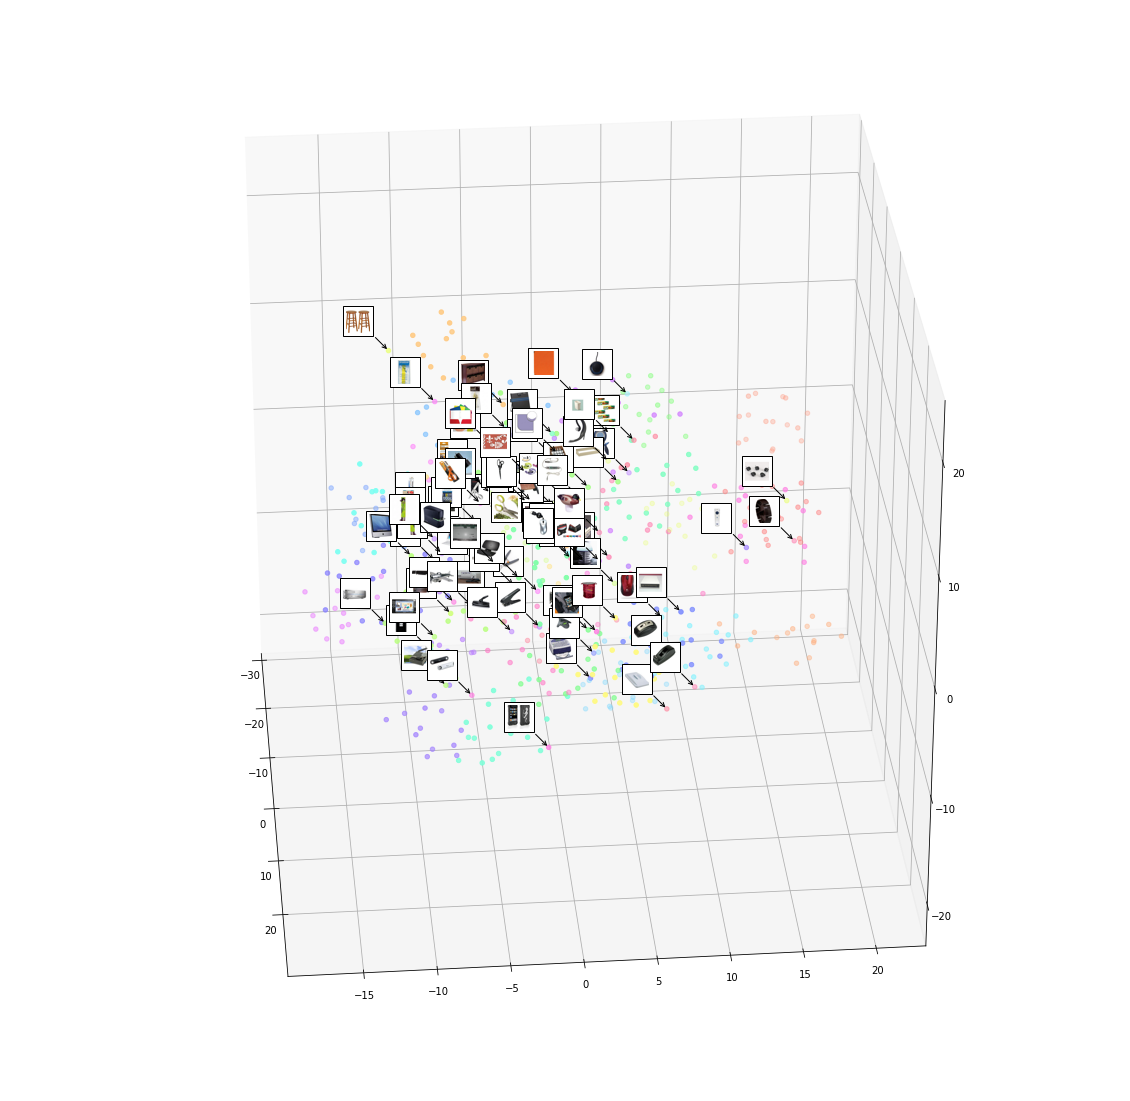

In [ ]:
cost_function = get_ce_loss()
eval_plot_3D(extractor,classifier,test_loader_a,cost_function,class_mapping,'./',frame_step=5,duration=100,layers=['identity'],device='cuda:0')